In [53]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import transforms

import sys
import numpy as np
import seaborn as sns
sys.path.append('..')
sys.path.append('../stylegan3')

from stylegan_generator import StyleGANGenerator

In [56]:
data_path = '/home/robert/data/diploma-thesis/datasets/stylegan3/tpsi_1/latents/sample_z.h5'
labels_path = '/home/robert/data/diploma-thesis/predictions/stylegan3/tpsi_1/resnet34_eyeglasses.pkl'

import pickle, h5py

labels = None
with open(labels_path,'rb') as f:
    labels = np.round(pickle.load(f))

data = None
with h5py.File(data_path, 'r') as f:
    data = f['z'][:]

zero_indices = np.where(labels == 0)[0]
zero_indices = np.random.choice(zero_indices, 22547, replace=False)

one_indices = np.where(labels == 1)[0]
indices = np.concatenate((one_indices, zero_indices))

labels = labels[indices]
data = data[indices]

dataset = TensorDataset(torch.Tensor(data),torch.Tensor(labels))
train_data, valid_data, test_data = random_split(dataset, [0.8, 0.1, 0.1])

<Axes: ylabel='Count'>

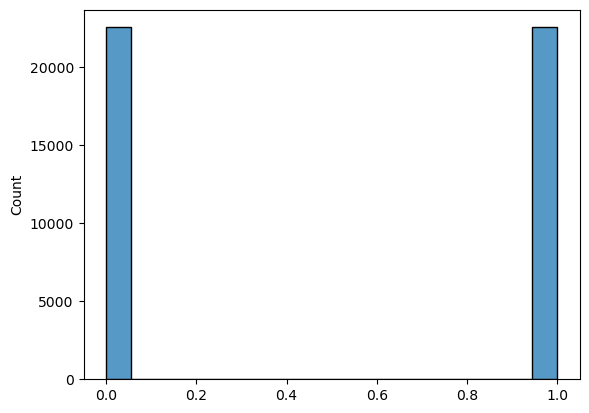

In [58]:
sns.histplot(labels)

In [68]:
class LatentEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 25))
        
        self.decoder = nn.Sequential(
            nn.Linear(257, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.Tanh())            
        
    def forward(self, x, y):
        latent = self.encoder(x)
        x = self.decoder(torch.cat((y.reshape((y.shape[0],-1)), latent),1))
        return x,latent

In [69]:
batch_size = 16
num_epochs = 100
learning_rate = 1e-4
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

model = LatentEncoder()
model.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate)

save_filename = 'latent_encoder_full_mse.pt'

loss = {}

loss['train'] = []
loss['valid'] = []
loss['test'] = []
best_valid_loss = np.inf

for epoch in range(num_epochs):
    model.train()
    for data in train_dataloader:
        x, y = data
        x = x.cuda()
        y = y.cuda()
               
        output,latent = model(x, y)
        train_loss = criterion(output, x)
       
        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    loss['train'].append(train_loss.data.item())
    
    model.eval()
    with torch.no_grad():
        for data in valid_dataloader:
            x, y = data
            x = x.cuda()
            y = y.cuda()
            
            output,latent = model(x, y)            
            val_loss = criterion(output, x)
            
    loss['valid'].append(val_loss.data.item())
    
    if loss['valid'][-1] < best_valid_loss:
        torch.save(model.state_dict(), save_filename)
        best_valid_loss = loss['valid'][-1]
   
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss["train"][-1]}, valid_loss:{loss["valid"][-1]}')
    

model.load_state_dict(torch.load(save_filename))

model.eval()
with torch.no_grad():
    for data in test_dataloader:
        x, y = data
        x = x.cuda()
        y = y.cuda()
        
        output,latent = model(x, y)
        test_loss = criterion(output, x)
        
        loss['test'].append(test_loss.data.item())

print(f'test_loss:{np.mean(np.array(loss["test"]))}')

epoch [1/100], loss:0.8272957801818848, valid_loss:0.8434566855430603
epoch [2/100], loss:0.7424864768981934, valid_loss:0.7587364315986633
epoch [3/100], loss:0.685261607170105, valid_loss:0.694598376750946
epoch [4/100], loss:0.6612449884414673, valid_loss:0.6980316638946533
epoch [5/100], loss:0.6265766620635986, valid_loss:0.6413677930831909
epoch [6/100], loss:0.6333529353141785, valid_loss:0.6446143388748169
epoch [7/100], loss:0.5802125334739685, valid_loss:0.6409716010093689
epoch [8/100], loss:0.6498796939849854, valid_loss:0.5973276495933533
epoch [9/100], loss:0.6116927862167358, valid_loss:0.5989212393760681
epoch [10/100], loss:0.5767245292663574, valid_loss:0.592162549495697
epoch [11/100], loss:0.5795062780380249, valid_loss:0.5986876487731934
epoch [12/100], loss:0.5861281156539917, valid_loss:0.5924682021141052
epoch [13/100], loss:0.5780353546142578, valid_loss:0.5974149703979492


KeyboardInterrupt: 

In [65]:
network_pkl = 'https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhqu-1024x1024.pkl'
generator = StyleGANGenerator(network_pkl)

In [67]:
test = torch.Tensor(np.random.randn(1,1024))
test_zero = torch.cat((torch.zeros((1,1)),test),1)
test_one = torch.cat((torch.ones((1,1)),test),1)

print(test_zero, test_one)

model.eval()
with torch.no_grad():
    pred_zero = model.decoder(test_zero.cuda())
    pred_one = model.decoder(test_one.cuda())
    
generator.generate_from('pred_zero.png', pred_zero.cpu().numpy().reshape(-1,512))
generator.generate_from('pred_one.png', pred_one.cpu().numpy().reshape(-1,512))

tensor([[ 0.0000, -0.6920, -1.0960,  ..., -2.0089, -0.3581, -0.2077]]) tensor([[ 1.0000, -0.6920, -1.0960,  ..., -2.0089, -0.3581, -0.2077]])
